In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import io

from dlrep.ImageCaptioning.utils import metrics, SaveModel, inference, VizAttention
from dlrep.ImageCaptioning.data.dataload import String2Int, load_meta
from dlrep.ImageCaptioning.models import ShowAttendTell

c:\Users\hanse\Documents\ml_code\DLReplications\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [18]:
train_meta = load_meta('./data/metadata/train_meta.json')
train_paths = ['./data'+path for path in train_meta['paths']]
valid_meta = load_meta("./data/metadata/valid_meta.json")
valid_paths = ['./data'+path for path in valid_meta['paths']]

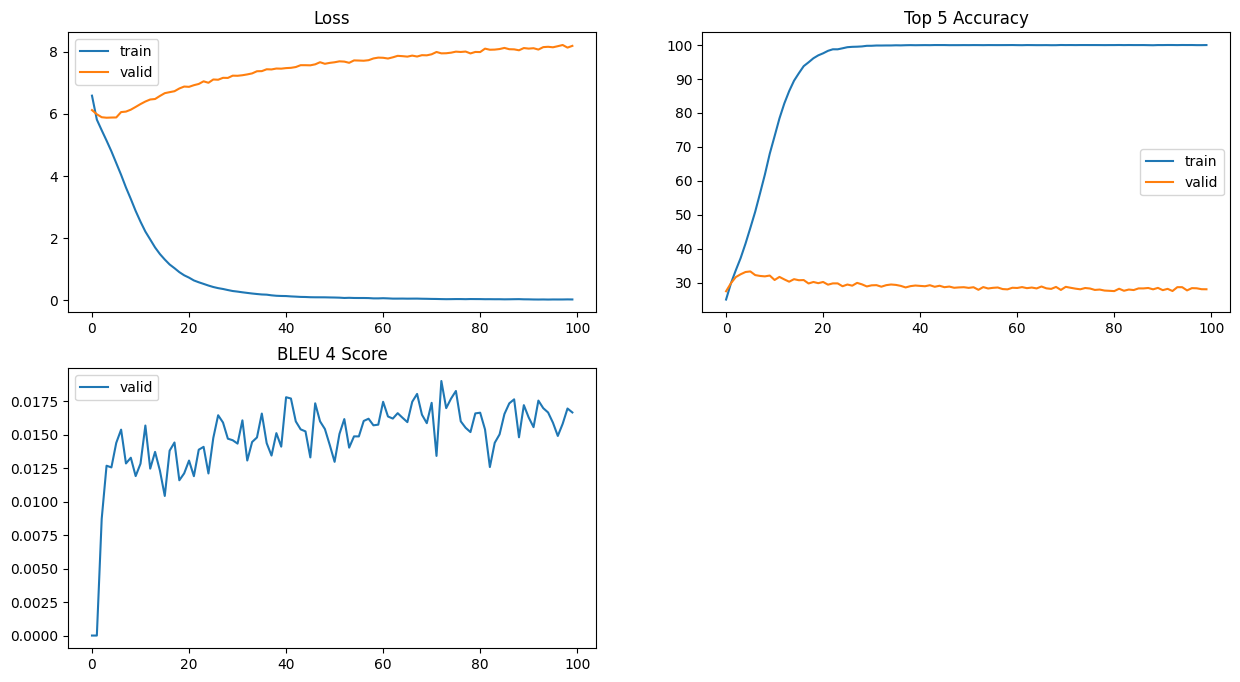

In [19]:
losses = metrics.LoadMetricLog("./logs/losses.txt")
val_losses = metrics.LoadMetricLog("./logs/val_losses.txt")
top5acc = metrics.LoadMetricLog("./logs/top5acc.txt")
val_top5acc = metrics.LoadMetricLog("./logs/val_top5acc.txt")
bleu4 = metrics.LoadMetricLog("./logs/bleu4.txt")

plt.figure(figsize=(15, 8))

plt.subplot(221)
plt.title("Loss")
plt.plot(losses, label="train")
plt.plot(val_losses, label="valid")
plt.legend()

plt.subplot(222)
plt.title("Top 5 Accuracy")
plt.plot(top5acc, label="train")
plt.plot(val_top5acc, label="valid")
plt.legend()

plt.subplot(223)
plt.title("BLEU 4 Score")
plt.plot(bleu4, label="valid")
plt.legend()

plt.show()

In [25]:
state_dicts, meta = SaveModel.load_checkpoint("./checkpoints/best_train-overfit.tar")
string2int = String2Int(saved_dict=meta['string2int_dict'])
config = meta['config']

In [26]:
encoder = ShowAttendTell.Encoder(weights='random')
decoder = ShowAttendTell.AttentionDecoder(config['dec_embed_dim'], config['dec_hidden_dim'], config['attention_dim'], string2int)
encoder.load_state_dict(encoder_dict)
decoder.load_state_dict(decoder_dict)

<All keys matched successfully>

In [27]:
encoder = encoder.to(device)
decoder = decoder.to(device)

In [31]:
imn = 100
image = inference.load_prep_image(valid_paths[imn], transforms=encoder.transforms).to(device)
image_notransform = inference.load_prep_image(valid_paths[imn], transforms=None)

In [32]:
caption, final_seq, bleu4, final_alpha = inference.beam_caption(image, encoder, decoder, string2int, beam_size=5)

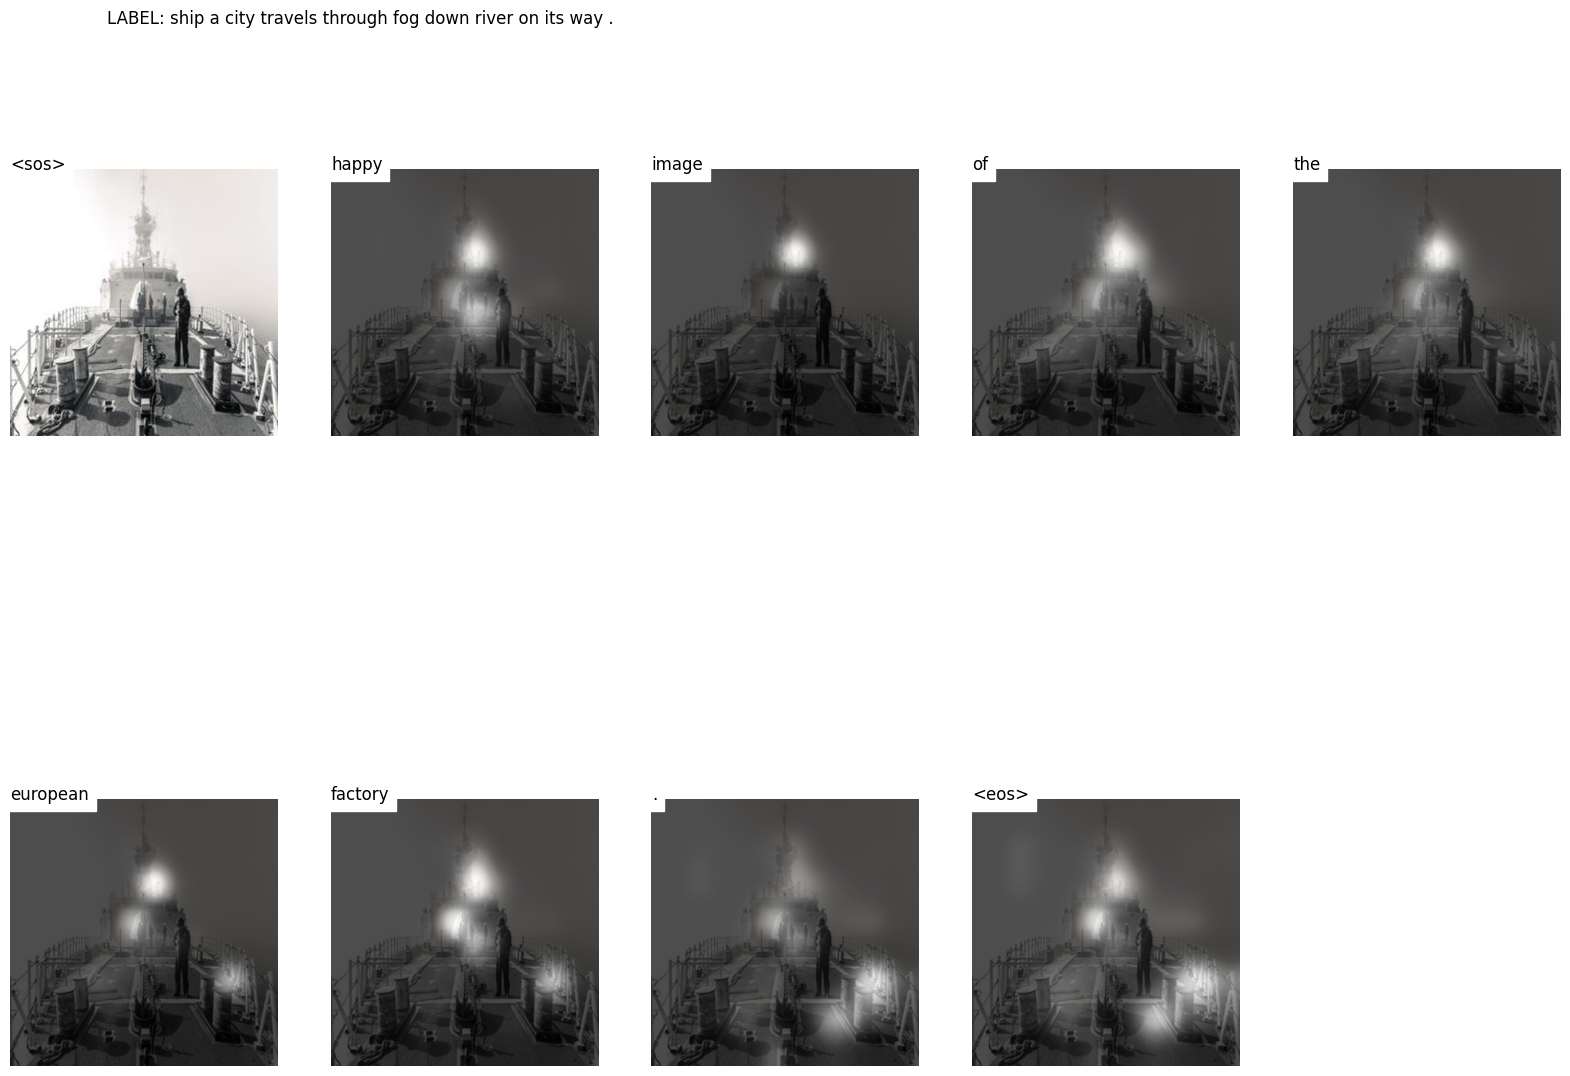

In [33]:
plt.figure(figsize=(20, 15))
VizAttention.plot_predicted(image_notransform, final_seq, final_alpha, string2int, smooth=True)
plt.suptitle("LABEL: "+valid_meta['labels'][imn], x=0.3, y=0.9)
plt.show()